In [1]:
import typing
from typing import Tuple
import json
import os

import torch
from torch import nn
from torch import optim
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import utils
from modules import Encoder, Decoder
from custom_types import DaRnnNet, TrainData, TrainConfig
from utils import numpy_to_tvar
from constants import device

logger = utils.setup_log()
logger.info(f"Using computation device: {device}")

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
2020-04-17 23:27:21,424 - VOC_TOPICS - INFO - Using computation device: cpu


In [0]:

def preprocess_data(dat, col_names) -> Tuple[TrainData, StandardScaler]:
    scale = StandardScaler().fit(dat)
    proc_dat = scale.transform(dat)

    mask = np.ones(proc_dat.shape[1], dtype=bool)
    dat_cols = list(dat.columns)
    for col_name in col_names:
        mask[dat_cols.index(col_name)] = False

    feats = proc_dat[:, mask]
    targs = proc_dat[:, ~mask]

    return TrainData(feats, targs), scale


def da_rnn(train_data: TrainData, n_targs: int, encoder_hidden_size=64, decoder_hidden_size=64,
           T=10, learning_rate=0.01, batch_size=128):

    train_cfg = TrainConfig(T, int(train_data.feats.shape[0] * 0.7), batch_size, nn.MSELoss())
    logger.info(f"Training size: {train_cfg.train_size:d}.")

    enc_kwargs = {"input_size": train_data.feats.shape[1], "hidden_size": encoder_hidden_size, "T": T}
    encoder = Encoder(**enc_kwargs).to(device)
    #with open(os.path.join("data", "enc_kwargs.json"), "w") as fi:
    #    json.dump(enc_kwargs, fi, indent=4)

    dec_kwargs = {"encoder_hidden_size": encoder_hidden_size,
                  "decoder_hidden_size": decoder_hidden_size, "T": T, "out_feats": n_targs}
    decoder = Decoder(**dec_kwargs).to(device)
    #with open(os.path.join("data", "dec_kwargs.json"), "w") as fi:
    #    json.dump(dec_kwargs, fi, indent=4)

    encoder_optimizer = optim.Adam(
        params=[p for p in encoder.parameters() if p.requires_grad],
        lr=learning_rate)
    decoder_optimizer = optim.Adam(
        params=[p for p in decoder.parameters() if p.requires_grad],
        lr=learning_rate)
    da_rnn_net = DaRnnNet(encoder, decoder, encoder_optimizer, decoder_optimizer)

    return train_cfg, da_rnn_net


In [0]:
def train(net: DaRnnNet, train_data: TrainData, t_cfg: TrainConfig, n_epochs=10, save_plots=False):
    iter_per_epoch = int(np.ceil(t_cfg.train_size * 1. / t_cfg.batch_size))
    iter_losses = np.zeros(n_epochs * iter_per_epoch)
    epoch_losses = np.zeros(n_epochs)
    logger.info(f"Iterations per epoch: {t_cfg.train_size * 1. / t_cfg.batch_size:3.3f} ~ {iter_per_epoch:d}.")

    n_iter = 0

    for e_i in range(n_epochs):
        perm_idx = np.random.permutation(t_cfg.train_size - t_cfg.T)

        for t_i in range(0, t_cfg.train_size, t_cfg.batch_size):
            batch_idx = perm_idx[t_i:(t_i + t_cfg.batch_size)]
            feats, y_history, y_target = prep_train_data(batch_idx, t_cfg, train_data)

            loss = train_iteration(net, t_cfg.loss_func, feats, y_history, y_target)
            iter_losses[e_i * iter_per_epoch + t_i // t_cfg.batch_size] = loss
            # if (j / t_cfg.batch_size) % 50 == 0:
            #    self.logger.info("Epoch %d, Batch %d: loss = %3.3f.", i, j / t_cfg.batch_size, loss)
            n_iter += 1

            adjust_learning_rate(net, n_iter)

        epoch_losses[e_i] = np.mean(iter_losses[range(e_i * iter_per_epoch, (e_i + 1) * iter_per_epoch)])

        if e_i % 10 == 0:
            y_test_pred = predict(net, train_data,
                                  t_cfg.train_size, t_cfg.batch_size, t_cfg.T,
                                  on_train=False)
            # TODO: make this MSE and make it work for multiple inputs
            val_loss = y_test_pred - train_data.targs[t_cfg.train_size:]
            logger.info(f"Epoch {e_i:d}, train loss: {epoch_losses[e_i]:3.3f}, val loss: {np.mean(np.abs(val_loss))}.")
            y_train_pred = predict(net, train_data,
                                   t_cfg.train_size, t_cfg.batch_size, t_cfg.T,
                                   on_train=True)
            plt.figure()
            plt.plot(range(1, 1 + len(train_data.targs)), train_data.targs,
                     label="True")
            plt.plot(range(t_cfg.T, len(y_train_pred) + t_cfg.T), y_train_pred,
                     label='Predicted - Train')
            plt.plot(range(t_cfg.T + len(y_train_pred), len(train_data.targs) + 1), y_test_pred,
                     label='Predicted - Test')
            plt.legend(loc='upper left')
            plt.show()
            #utils.save_or_show_plot(f"pred_{e_i}.png", save_plots)

    return iter_losses, epoch_losses


In [0]:

def prep_train_data(batch_idx: np.ndarray, t_cfg: TrainConfig, train_data: TrainData):
    feats = np.zeros((len(batch_idx), t_cfg.T - 1, train_data.feats.shape[1]))
    y_history = np.zeros((len(batch_idx), t_cfg.T - 1, train_data.targs.shape[1]))
    y_target = train_data.targs[batch_idx + t_cfg.T]

    for b_i, b_idx in enumerate(batch_idx):
        b_slc = slice(b_idx, b_idx + t_cfg.T - 1)
        feats[b_i, :, :] = train_data.feats[b_slc, :]
        y_history[b_i, :] = train_data.targs[b_slc]

    return feats, y_history, y_target


def adjust_learning_rate(net: DaRnnNet, n_iter: int):
    # TODO: Where did this Learning Rate adjustment schedule come from?
    # Should be modified to use Cosine Annealing with warm restarts https://www.jeremyjordan.me/nn-learning-rate/
    if n_iter % 10000 == 0 and n_iter > 0:
        for enc_params, dec_params in zip(net.enc_opt.param_groups, net.dec_opt.param_groups):
            enc_params['lr'] = enc_params['lr'] * 0.9
            dec_params['lr'] = dec_params['lr'] * 0.9


def train_iteration(t_net: DaRnnNet, loss_func: typing.Callable, X, y_history, y_target):
    t_net.enc_opt.zero_grad()
    t_net.dec_opt.zero_grad()

    input_weighted, input_encoded = t_net.encoder(numpy_to_tvar(X))
    y_pred = t_net.decoder(input_encoded, numpy_to_tvar(y_history))

    y_true = numpy_to_tvar(y_target)
    loss = loss_func(y_pred, y_true)
    loss.backward()

    t_net.enc_opt.step()
    t_net.dec_opt.step()

    return loss.item()


In [0]:

def predict(t_net: DaRnnNet, t_dat: TrainData, train_size: int, batch_size: int, T: int, on_train=False):
    out_size = t_dat.targs.shape[1]
    if on_train:
        y_pred = np.zeros((train_size - T + 1, out_size))
    else:
        y_pred = np.zeros((t_dat.feats.shape[0] - train_size, out_size))

    for y_i in range(0, len(y_pred), batch_size):
        y_slc = slice(y_i, y_i + batch_size)
        batch_idx = range(len(y_pred))[y_slc]
        b_len = len(batch_idx)
        X = np.zeros((b_len, T - 1, t_dat.feats.shape[1]))
        y_history = np.zeros((b_len, T - 1, t_dat.targs.shape[1]))

        for b_i, b_idx in enumerate(batch_idx):
            if on_train:
                idx = range(b_idx, b_idx + T - 1)
            else:
                idx = range(b_idx + train_size - T, b_idx + train_size - 1)

            X[b_i, :, :] = t_dat.feats[idx, :]
            y_history[b_i, :] = t_dat.targs[idx]

        y_history = numpy_to_tvar(y_history)
        _, input_encoded = t_net.encoder(numpy_to_tvar(X))
        y_pred[y_slc] = t_net.decoder(input_encoded, y_history).cpu().data.numpy()

    return y_pred



In [0]:

save_plots = False
debug = False

In [7]:
raw_data = pd.read_csv(os.path.join("nasdaq100_padding.csv"), nrows=100 if debug else None)
logger.info(f"Shape of data: {raw_data.shape}.\nMissing in data: {raw_data.isnull().sum().sum()}.")
targ_cols = ("NDX",)
data, scaler = preprocess_data(raw_data, targ_cols)

2020-04-17 23:28:50,902 - VOC_TOPICS - INFO - Shape of data: (40560, 82).
Missing in data: 0.


In [0]:

da_rnn_kwargs = {"batch_size": 128, "T": 10}


In [13]:
config, model = da_rnn(data, n_targs=len(targ_cols), learning_rate=.001,batch_size=128)


2020-04-17 23:33:44,554 - VOC_TOPICS - INFO - Training size: 28392.


2020-04-17 23:39:06,204 - VOC_TOPICS - INFO - Iterations per epoch: 221.812 ~ 222.
2020-04-17 23:39:41,767 - VOC_TOPICS - INFO - Epoch 0, train loss: 0.003, val loss: 0.1107443040960039.


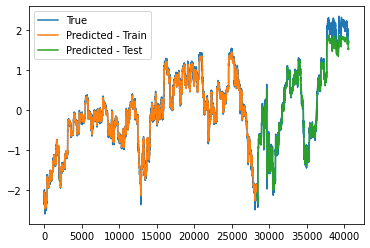

In [20]:
iter_loss, epoch_loss = train(model, data, config, n_epochs=10, save_plots=save_plots)


In [0]:
final_y_pred = predict(model, data, config.train_size, config.batch_size, config.T)

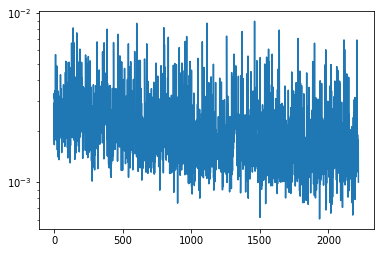

In [22]:

plt.figure()
plt.semilogy(range(len(iter_loss)), iter_loss)
utils.save_or_show_plot("iter_loss.png", save_plots)


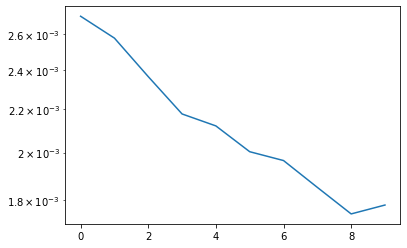

In [23]:

plt.figure()
plt.semilogy(range(len(epoch_loss)), epoch_loss)
utils.save_or_show_plot("epoch_loss.png", save_plots)

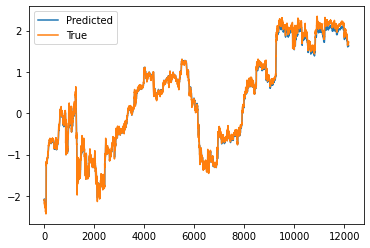

In [24]:

plt.figure()
plt.plot(final_y_pred, label='Predicted')
plt.plot(data.targs[config.train_size:], label="True")
plt.legend(loc='upper left')
utils.save_or_show_plot("final_predicted.png", save_plots)